# Lesson 1 - Keras implementation of fast ai part 1 v2
- This is a Keras implementation of Jeremy Howard's fastai part 1 v2 lesson 1 (original version is in PyTorch)
- This has only been tested with the TensorFlow backend to Keras

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from fastai.utils import *
from fastai.learner import *
from fastai.dataset import *

Using TensorFlow backend.


We will use the dogs and cats dataset

path should be replaced with the path to your downloaded dogs and cats dataset

For the original Keras dogs/cats lesson1 and instructions on downloading visit:
https://github.com/fastai/courses/blob/master/deeplearning1/nbs/lesson1.ipynb

In [2]:
path="/home/jeff/projects/fastai/data/dogscats/" #update with your path to cats and dogs
sz = 224

Loading in Keras' off the shelf/pretrained ResNet50 model.

***note: the PyTorch course uses ResNet34. After many hours spent writing code to convert PyTorch models and weights into Keras. I opted to use Keras' ResNet50.***

In [3]:
arch = ResNet50
data = ImageClassifierData.from_paths(path=path, tfms = tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, finetune2_layer='avg_pool')

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [4]:
learn.lr_find(jump=8)

Epoch 1/1
130/360 [=========>....................] - ETA: 45s - loss: 0.6037

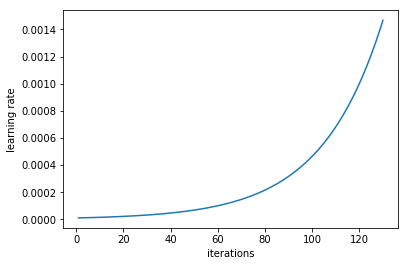

In [5]:
learn.sched.plot_lr()

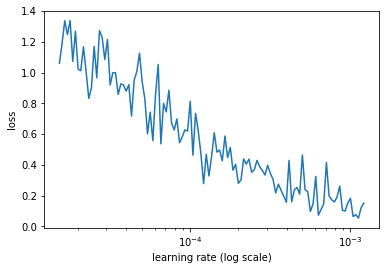

In [6]:
learn.sched.plot()

As you can see in the plot above it appears the optimal learning rate to set is .08

**Data Augmentation on the training data**

Now time to start training!  I noticed that the pretrained Keras ResNet50 model is not quite as accurate in my opinion as the pretrained PyTorch ResNet50 model.

In [7]:
tfms = tfms_from_model(arch, sz, crop_type=CropType.RANDOM, 
                  rotation_range=10, zoom_range=0.1, horizontal_flip=True)

In [8]:
#need to add random lighten
data = ImageClassifierData.from_paths(path=path, tfms = tfms)
learn = ConvLearner.pretrained(arch, data, finetune2_layer='avg_pool')

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [9]:
learn.fit(.08, 4)

Epoch 1/4
360/360 [==============================] - 74s - loss: 0.5111 - acc: 0.9583 - val_loss: 0.4893 - val_acc: 0.9660
Epoch 2/4
360/360 [==============================] - 74s - loss: 0.3991 - acc: 0.9693 - val_loss: 0.3730 - val_acc: 0.9745
Epoch 3/4
360/360 [==============================] - 73s - loss: 0.4235 - acc: 0.9685 - val_loss: 0.4174 - val_acc: 0.9710
Epoch 4/4
360/360 [==============================] - 73s - loss: 0.3825 - acc: 0.9726 - val_loss: 0.3309 - val_acc: 0.9765


Evaluate function may run a little slow.  I find that Keras generator's are not the fastest compared to the ones in the fastai PyTorch library.  Generally I try to load the entire dataset into memory, but since this repository is meant to be shared I opted for generators so that it works for a wider audience.

Fit for 3 epochs with a Cyclical Learning Rate

In [10]:
learn.fit(.08, 3, cycle_len=1, cycle_mult=1)

Epoch 1/3
360/360 [==============================] - 74s - loss: 0.3398 - acc: 0.9748 - val_loss: 0.2787 - val_acc: 0.9795
Epoch 2/3
360/360 [==============================] - 74s - loss: 0.2956 - acc: 0.9779 - val_loss: 0.2829 - val_acc: 0.9795
Epoch 3/3
360/360 [==============================] - 75s - loss: 0.3067 - acc: 0.9769 - val_loss: 0.2682 - val_acc: 0.9805


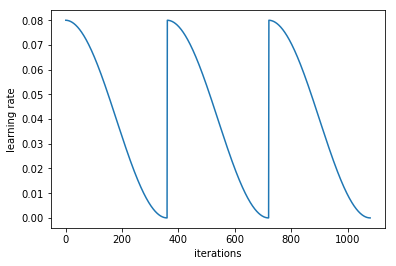

In [11]:
learn.sched.plot_lr()

In [12]:
learn.save('keras_resnet50_f2.hdf5')

Make all layers trainable

In [13]:
learn.unfreeze()

In [14]:
learn.fit([0.0001, .001, .01], 3, cycle_len=1, cycle_mult=2)

Epoch 1/7
360/360 [==============================] - 213s - loss: 0.2953 - acc: 0.9776 - val_loss: 0.2351 - val_acc: 0.9815
Epoch 2/7
360/360 [==============================] - 212s - loss: 0.2480 - acc: 0.9815 - val_loss: 0.2162 - val_acc: 0.9825
Epoch 3/7
360/360 [==============================] - 213s - loss: 0.2007 - acc: 0.9838 - val_loss: 0.2062 - val_acc: 0.9835
Epoch 4/7
360/360 [==============================] - 211s - loss: 0.2044 - acc: 0.9846 - val_loss: 0.2338 - val_acc: 0.9820
Epoch 5/7
360/360 [==============================] - 213s - loss: 0.1772 - acc: 0.9862 - val_loss: 0.1884 - val_acc: 0.9855
Epoch 6/7
360/360 [==============================] - 211s - loss: 0.1347 - acc: 0.9897 - val_loss: 0.1788 - val_acc: 0.9855
Epoch 7/7
360/360 [==============================] - 211s - loss: 0.1299 - acc: 0.9899 - val_loss: 0.1604 - val_acc: 0.9880


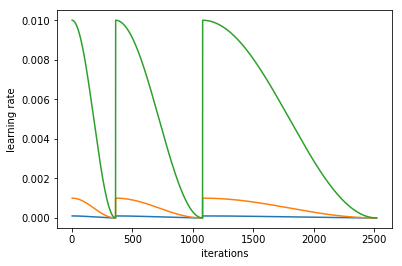

In [15]:
learn.sched.plot_lr()

In [16]:
%%time
learn.model.evaluate_generator(data[1], steps=math.ceil(data[1].samples/data[1].batch_size), workers=4 )

CPU times: user 19.5 s, sys: 372 ms, total: 19.8 s
Wall time: 8.06 s


[0.16255592977277877, 0.98699999999999999]

In [17]:
learn.save('keras_resnet50_f2_2.hdf5')